In [2]:
from skimage import data, io, filters, restoration
from skimage.util import view_as_windows as viewW
from matplotlib import pyplot as plt
import cv2 as cv
import scipy
import numpy
import math

In [127]:
def im2col_sliding_strided_v2(A, BSZ, stepsize=1):
    return viewW(A, (BSZ[0],BSZ[1])).reshape(-1,BSZ[0]*BSZ[1]).T[:,::stepsize]

## Resources

- Source code: https://uk.mathworks.com/matlabcentral/fileexchange/36921-noise-level-estimation-from-a-single-image
- MATLAB to python: https://cheatsheets.quantecon.org/, http://mathesaurus.sourceforge.net/matlab-numpy.html



In [128]:
"""
Output params:
nlevel: estimated noise level
th: threshold to extract weak texture patches at the last iteration
num: number of extracted weak texture patches

Input Params:
img: intput single image
patchsize (optional): patch size(default: 7)
decim (optional): decimation factor. Large number = accelerated calculation 
                  (default: 0)
conf (optional): confidence interval to determin the treshold for the 
                 weak texture. usually very close to one (default: 0.99)
itr (optional): number of iterations (default: 3)
"""

def NoiseLevel(img, patchsize = 7, decim = 0, conf = None, itr = 3):
    if not conf:
        conf = 1-1e-6
    kh = numpy.array([[[-1/2],[0],[1/2]]])
    imgh = scipy.ndimage.correlate(img.astype(numpy.float32), kh, mode="nearest")
    imgh = imgh[:,1:len(imgh[1])-1,:]
    imgh = numpy.multiply(imgh, imgh)
    
    kv = numpy.array([[[-1/2]],[[0]],[[1/2]]])
    imgv = scipy.ndimage.correlate(img.astype(numpy.float32), kv, mode="nearest")
    imgv = imgv[1:len(imgv)-1,:,:]
    imgv = numpy.multiply(imgv, imgv)
    
    
    Dh = my_convmtx(kh, patchsize, patchsize)
    Dv = my_convmtx(kv, patchsize, patchsize)
    DD = Dh.conj().transpose().dot(Dh)\
         +Dv.conj().transpose().dot(Dv)
    r = numpy.linalg.matrix_rank(DD)
    Dtr = DD.trace(offset=0);
    tau0 = scipy.stats.gamma.ppf(conf,float(r)/2, scale = 2.0 * Dtr / float(r));
    
    nlevel = []
    th = []
    num = []
    for cha in range(img.shape[2]):
        X = im2col_sliding_strided_v2(img.astype(numpy.float32)[:,:,cha],(patchsize, patchsize))
        Xh = im2col_sliding_strided_v2(imgh[:,:,cha],(patchsize, patchsize-2))
        Xv = im2col_sliding_strided_v2(imgv[:,:,cha],(patchsize-2, patchsize))
        print(Xv.T)
        print(Xh)
       
        Xtr = numpy.vstack((Xv,Xh)).sum(axis=0)[numpy.newaxis]
        print(Xtr)
        if decim > 0:
            XtrX = numpy.vstack((Xtr,X));
            XtrX = sortrows(XtrX.conj().transpose())
            p = math.floor(XtrX.shape[1]/(decim+1))
            p = numpy.array(range(0,p)) * (decim+1)
            Xtr = XtrX[1].take(p, axis=1)
            X = XtrX[2:size(XtrX,1)].take(p, axis=1)
        # Noise level estimation
        tau = math.inf
        if X.shape[1] < X.shape[0]:
            sig2 = 0
        else:
            cov = X.dot((X.conj().T))/(X.shape[1]-1)
            d = numpy.linalg.eigvals(cov)
            d.sort()
            sig2 = d[0]
        for i in range(2,itr+1):
            # weak texture selection
            tau = sig2 * tau0
            print(Xtr[0,50])
            p = [1 if pp < tau else 0 for pp in Xtr[0]]
            print(p[55])
            Xtr = Xtr.take(p,axis=1)
            print(Xtr)
            X = X.take(p,axis=1)
            
            # noise level estimation
            if X.shape[1] < X.shape[0]:
                break

            cov = X.dot((X.conj().T))/(X.shape[1]-1)
            d = numpy.linalg.eigvals(cov)
            d.sort()
            sig2 = d[0]
        nlevel.append(math.sqrt(sig2))
        th.append(tau)
        num.append(X.shape[1])
    
    return nlevel, th, num
            
            
        

In [129]:
def my_convmtx(H, m, n):
    s = H.shape
    T = numpy.zeros((((m-s[0]+1)*(n-s[1]+1)), (m*n)), float)
    k = 0
    for i in range(1,(m-s[0]+2)):
        for j in range(1,(n-s[1]+2)):
            for p in range(1,s[0]+1):
                h_index = p-1
                for x in range((i-1+p-1)*n+(j-1),(i-1+p-1)*n+(j-1)+s[1]):
                    T[k,x] = H.flatten()[h_index]
                    h_index += 1
            k += 1
    return T
    
        

In [130]:
"""
Output parameters:
msk: weak texture mask. 0 and 1 represent non-weak-texture and weak-texture
     respectively

Input Parameters:
img: input single image
th: threshold which is output of NoiseLevel
patchsize (optional): patchsize (default: 7)
"""
def weakTextureMask(img, th, patchsize=7):
    kh = numpy.array([-1/2, 0, 1/2])
    imgh = scipy.ndimage.correlate(img.astype(numpy.float64), kh, mode="nearest")
    imgh = imgh[:,1:len(imgh[1])-1,:]
    imgh = numpy.multiply(imgh, imgh)
    print(imgh.shape)
    
    kv = kh.conj().transpose()
    imgv = scipy.ndimage.correlate(img, kv, mode="nearest")
    imgv = imgv[1:len(imgv[0])-1][:][:]
    imgv = numpy.multiply(imgv, imgv)
    print(imgv.shape)
    
    s = img.shape
    msk = numpy.zeros(s, Float)
    
    for cha in range(0,s[2]):
        m = im2col_sliding_strided_v2(img[:][:][cha],(patchsize, patchsize))
        m = numpy.zeros(m.shape)
        Xh = im2col_sliding_strided_v2(imgh[:][:][cha],(patchsize, patchsize-2))
        Xv = im2col_sliding_strided_v2(imgv[:][:][cha],(patchsize-2, patchsize))
        
        Xtr = numpy.vstack((Xh,Xv)).sum(axis=0)
        
        p = [1 if p < th[cha] else 0 for p in Xtr]
        ind = 0
        for col in range(s[1]-patchsize):
            for row in range(s[0]-patchsize):
                if p[ind] > 0:
                    msk [row:row+patchsize, col:col+patchsize-1, cha] = 1
                ind += 1
    return msk

    

In [131]:
test_image = cv.imread('images/167083.jpg')
for x in range(test_image.shape[0]):
    for y in range(test_image.shape[1]):
        test_image[x,y,0], test_image[x,y,2] = test_image[x,y,2], test_image[x,y,0]


In [132]:
nlevel, th, num = NoiseLevel(test_image)

/home/sam/.local/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


[[0.   0.   0.   ... 0.   0.   0.25]
 [0.   0.   0.   ... 0.   0.25 0.25]
 [0.   0.   0.   ... 0.25 0.25 0.25]
 ...
 [0.   0.   0.   ... 1.   2.25 6.25]
 [0.   0.   0.25 ... 2.25 6.25 2.25]
 [0.   0.25 1.   ... 6.25 2.25 0.25]]
[[0.   0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 2.25]
 [0.25 0.25 0.25 ... 0.25 2.25 1.  ]
 ...
 [0.25 0.25 0.   ... 0.25 0.25 0.  ]
 [0.25 0.   0.25 ... 0.25 0.   0.  ]
 [0.   0.25 0.25 ... 0.   0.   0.25]]
[[15.   19.   19.5  ... 55.5  57.   70.25]]
3.75
1
[[19. 19. 19. ... 19. 19. 19.]]
19.0
0
[[19. 19. 19. ... 19. 19. 19.]]


/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:85: ComplexWarning: Casting complex values to real discards the imaginary part


ValueError: math domain error

In [3]:
def add_gaussian_noise(img):
    m = (0,0,0) 
    s = (2,2,2)  
    noise = numpy.zeros(img.shape)
    cv.randn(noise,m,s)
    new_img = (img+noise) 
    new_img = (new_img - new_img.min()) * (255/new_img.max())
    return new_img

Fitness when applying no denoising algorithm:  104998575
-------------
Fitness after applying denoising algorithm:  72110849


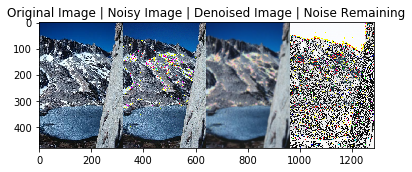


Testing fitness funtion with optional display parameter:


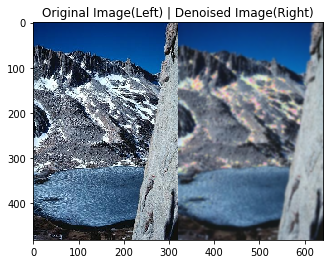

Result:  -754687


In [18]:
fitness_test_image = cv.imread('images/167083.jpg')

noisy_test_images = fitness_test_image.copy()

noisy_test_images = add_gaussian_noise(noisy_test_images).astype(numpy.uint8)

denoised_test_image = filters.gaussian(noisy_test_images,sigma=2)
denoised_test_image *= 255
denoised_test_image = denoised_test_image.astype(numpy.uint8)

baseline = fitness_test_image - noisy_test_images

test_fitness = fitness_test_image - denoised_test_image

print("Fitness when applying no denoising algorithm: ",numpy.absolute(baseline).sum())
print("-------------")
print("Fitness after applying denoising algorithm: ", numpy.absolute(test_fitness).sum())

all_images_merged = numpy.hstack((fitness_test_image,noisy_test_images,denoised_test_image,test_fitness))
rgb_all_images = cv.cvtColor(all_images_merged, cv.COLOR_BGR2RGB)
plt.imshow(rgb_all_images)
plt.title("Original Image | Noisy Image | Denoised Image | Noise Remaining")
plt.show()

print("\nTesting fitness funtion with optional display parameter:")
print("Result: ", evaluate_fitness(denoised_test_image, fitness_test_image, display_images=True))
      
def evaluate_fitness(denoised_image, original_image, display_images=False):
    
    if display_images:
        
        merged_images = numpy.hstack((original_image,denoised_image))
        rgb_merged_images = cv.cvtColor(merged_images, cv.COLOR_BGR2RGB)
        plt.title("Original Image(Left) | Denoised Image(Right)")
        plt.imshow(rgb_merged_images)
        plt.show()
        
    return int(numpy.absolute(original_image).sum()) - int(numpy.absolute(denoised_image).sum())